# Imports

In [8]:
from pathlib import Path
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import entropy, chi2_contingency
from sklearn.metrics.pairwise import rbf_kernel
from tqdm.auto import trange
from typing import Callable, Dict, List, Tuple

# User Configuration

In [9]:
SAVE_DATA = True  # Save results as CSV and figures

SUBSET_SIZE = 10_000       # Number of samples per run, recommended ≤10k; approx. 30 sec. per MC run with 10k samples
N_RUNS = 30                # Number of Monte Carlo repetitions (recommend ≥30)
RANDOM_STATE = 42          # Seed for reproducibility

REAL_FILE = "20250301_data_20250510_122405_final_100_train.csv"
SYNTH_FILE = "20250301_data_20250510_122405_final_100_synth.csv"

DATA_DIR = Path("../../data")
OUTPUT_DIR_CSV = Path("results")
OUTPUT_DIR_CSV.mkdir(parents=True, exist_ok=True)  # ensure output folder exists
OUTPUT_DIR_FIG = Path("figures")
OUTPUT_DIR_FIG.mkdir(parents=True, exist_ok=True)  # ensure output folder exists

AGE_BINS = [-np.inf, 29, 60, np.inf]
AGE_LABELS = ["<30", "30-60", ">60"]

# Set my design
sns.set_theme(
    style="white",
    context="paper",
    palette="colorblind",
    rc={
        "font.family": "sans-serif",
        "font.sans-serif": ["Arial"],
        "font.size": 7,
        "axes.titlesize": 7,
        "axes.labelsize": 7,
        "xtick.labelsize": 7,
        "ytick.labelsize": 7,
        "legend.fontsize": 7
    }
)

# Utility Functions

In [10]:
def add_age_group_column(df, col="age", new_col="age_group"):
    """Cut age into three bins."""
    df[new_col] = pd.cut(df[col], bins=AGE_BINS, labels=AGE_LABELS, right=False)

def median_heuristic_gamma(x: np.ndarray) -> float:
    """Compute RBF gamma via median heuristic."""
    if x.ndim == 1:
        x = x[:, None]
    # pairwise distances
    dists = np.sqrt(((x[:, None, :] - x[None, :, :])**2).sum(-1))
    # median of non-zero distances
    sigma = np.median(dists[dists > 0])
    return 1.0 / (2.0 * sigma**2) if sigma > 0 else 1.0

def compute_mmd(x: np.ndarray, y: np.ndarray, gamma: float=None) -> float:
    """Unbiased RBF-MMD (square-root scale) for 1D samples."""
    x = x.reshape(-1, 1)
    y = y.reshape(-1, 1)
    if gamma is None:
        gamma = median_heuristic_gamma(np.vstack([x, y]))
    k_xx = rbf_kernel(x, x, gamma=gamma)
    k_yy = rbf_kernel(y, y, gamma=gamma)
    k_xy = rbf_kernel(x, y, gamma=gamma)
    m, n = len(x), len(y)
    mmd2 = ((k_xx.sum() - np.trace(k_xx)) / (m*(m-1))
           + (k_yy.sum() - np.trace(k_yy)) / (n*(n-1))
           - 2 * k_xy.mean())
    return np.sqrt(max(mmd2, 0))

def _global_range(
    distributions: Dict[str, Dict[str, List[float]]],
    features: List[str],
    mapper: Callable[[np.ndarray, np.ndarray], np.ndarray],
) -> Tuple[float, float]:
    """Compute global min/max over mapped arrays."""
    mapped = []
    for feat in features:
        real = np.mean(distributions[feat]["real"], axis=0)
        synth = np.mean(distributions[feat]["synth"], axis=0)
        mapped.append(mapper(real, synth))
    flat = np.concatenate(mapped)
    return float(flat.min()), float(flat.max())

def get_global_range(
    distributions: Dict[str, Dict[str, List[float]]],
    features: List[str],
    mode: str = "diff",
) -> Tuple[float, float]:
    """
    Compute global min and max over distributions.
    
    mode="diff" → (synth - real)*100  
    mode="comp" → both real*100 and synth*100  
    """
    if mode == "diff":
        mapper = lambda r, s: (s - r) * 100
    elif mode == "comp":
        mapper = lambda r, s: np.concatenate([r * 100, s * 100])
    else:
        raise ValueError(f"Unknown mode {mode!r}")
    return _global_range(distributions, features, mapper)


# Data Loading

In [11]:
def load_data(real_filename: str, synth_filename: str) -> tuple[pd.DataFrame, pd.DataFrame]:
    """Read real and synthetic CSVs into DataFrames."""
    df_real = pd.read_csv(DATA_DIR / real_filename, low_memory=False)
    df_synth = pd.read_csv(DATA_DIR / synth_filename, low_memory=False)
    # add derived columns
    add_age_group_column(df_real)
    add_age_group_column(df_synth)

    return df_real, df_synth

# Metric Computation

In [12]:
def compute_categorical_metrics(df_real: pd.DataFrame,
                                df_synth: pd.DataFrame,
                                subset_size: int,
                                n_runs: int,
                                random_state: int
                               ) -> tuple[pd.DataFrame, dict]:
    """
    Perform Monte Carlo sampling and compute KL, Chi2, MMD per subgroup,
    and collect real vs synth frequency distributions (incl. category labels).
    Returns:
      - df_metrics: DataFrame mit mean/std der Kennzahlen pro Subgroup
      - distributions: dict[feature] -> {
            'categories': [Label1, Label2, …],
            'real': [array(run1), array(run2), …],
            'synth': [array(run1), array(run2), …]
        }
    """
    rng = np.random.default_rng(random_state)
    features = ["gender", "ethnicity", "age_group"]

    # fixe Reihenfolge der Kategorien für jede Feature
    categories = {
        feat: sorted(set(df_real[feat].dropna().unique())
                     | set(df_synth[feat].dropna().unique()))
        for feat in features
    }

    # Ergebnis-Container
    results = []
    distributions = {
        feat: {
            "categories": categories[feat],
            "real": [],
            "synth": []
        }
        for feat in features
    }

    for run in trange(n_runs, desc="MC runs"):
        real_s  = df_real.sample(subset_size, random_state=int(rng.integers(1e9)), replace=True) # Replace = True -> echtes Bootstrapping
        synth_s = df_synth.sample(subset_size, random_state=int(rng.integers(1e9)), replace=True)

        for feat in features:
            idx = categories[feat]
            # relative Häufigkeiten
            p_real  = real_s[feat].value_counts(normalize=True).reindex(idx, fill_value=0)
            p_synth = synth_s[feat].value_counts(normalize=True).reindex(idx, fill_value=0)

            # speichern für Heatmaps
            distributions[feat]["real"].append(p_real.to_numpy())
            distributions[feat]["synth"].append(p_synth.to_numpy())

            # KL-Divergenz
            kl = entropy(p_real, p_synth)
            # Chi2-Test auf Counts
            counts = np.vstack([p_real*subset_size, p_synth*subset_size])
            chi2_stat, chi2_p, *_ = chi2_contingency(counts)
            # MMD auf integer-codierten Kategorien
            mapping = {cat: i for i, cat in enumerate(idx)}
            x = real_s[feat].map(mapping).dropna().to_numpy()
            y = synth_s[feat].map(mapping).dropna().to_numpy()
            mmd = compute_mmd(x, y)

            results.append({
                "subgroup": feat,
                "KL_mean": kl,
                "Chi2_stat": chi2_stat,
                "Chi2_p": chi2_p,
                "MMD": mmd
            })

    df_metrics = (pd.DataFrame(results)
                    .groupby("subgroup")
                    .agg(["mean", "std"]))
    return df_metrics, distributions

# Heatmap Computation

In [35]:
def plot_heatmap_for_feature(distributions: dict, feat: str, vmin_vmax_diff: tuple = None, vmin_vmax_comp: tuple = None, fig_width: int = 8, fig_height: int = 4, show_diff_hm: bool = True) -> plt.Figure:
    """
    Plot real vs. synth frequencies side-by-side (left) and their difference (right) as heatmaps.
    Expects distributions with 'categories', 'real' and 'synth'.
    """

    cats        = distributions[feat]["categories"]
    real_vals   = np.array(distributions[feat]["real"]).mean(axis=0)
    synth_vals  = np.array(distributions[feat]["synth"]).mean(axis=0)
    diff_vals   = synth_vals - real_vals

    # Combined DataFrame für Real und Synth
    df_comp = pd.DataFrame({
        "Real (%)":  real_vals * 100,
        "Synth (%)": synth_vals * 100
    }, index=cats)

    # DataFrame nur für die Differenz
    df_diff = pd.DataFrame({
        "Δ (%)": diff_vals * 100
    }, index=cats)

    # Reorder the DataFrames
    if feat == "age_group":
        desired_order = ["<30", "30-60", ">60"]
        df_comp = df_comp.reindex(desired_order)
        df_diff = df_diff.reindex(desired_order)

    # Plot
    if show_diff_hm:
        fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(fig_width, fig_height), gridspec_kw={
            "width_ratios": [2, 1]
        })
    else:
        # Only one heatmap for comparison
        fig, ax1 = plt.subplots(figsize=(fig_width, fig_height))
        ax2 = None

    # Linke Heatmap: Real vs. Synth
    local_min_comp = df_comp.min().min()
    local_max_comp = df_comp.max().max()
    vmin_comp, vmax_comp = vmin_vmax_comp if vmin_vmax_comp else (local_min_comp, local_max_comp)

    sns.heatmap(
        df_comp, ax=ax1, annot=True, fmt=".1f",
        cmap="viridis",
        cbar_kws={"label": "%"}, yticklabels=True,
        vmin=vmin_comp, vmax=vmax_comp
    )
    ax1.set_title(f"{feat}: Real vs. Synth")

    # Rechte Heatmap: Differenz
    if show_diff_hm:
        local_vmax_diff = abs(diff_vals * 100).max()
        vmin_diff, vmax_diff = vmin_vmax_diff if vmin_vmax_diff else (-local_vmax_diff, local_vmax_diff)

        sns.heatmap(
            df_diff, ax=ax2, annot=True, fmt="+.1f",
            cmap="RdBu_r", center = 0,
            cbar_kws={"label": "Δ Prozentpunkte"},
            vmin=vmin_diff, vmax=vmax_diff
        )
        ax2.set_title("Difference (Synth - Real)")

    plt.tight_layout()

    return fig

# Main Execution

In [14]:
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
df_real, df_synth = load_data(REAL_FILE, SYNTH_FILE)

cat_metrics, distributions = compute_categorical_metrics(
    df_real, df_synth, SUBSET_SIZE, N_RUNS, RANDOM_STATE
)
print("Categorical metrics (mean ± std):")
print(cat_metrics)
if SAVE_DATA:
    cat_metrics.to_csv(OUTPUT_DIR_CSV / f"cat_metrics_{timestamp}.csv",
                        sep=";", decimal=",", encoding="utf-8")
    print(f"Saved categorical metrics to {OUTPUT_DIR_CSV / f'cat_metrics_{timestamp}.csv'}")
    distributions_df = pd.DataFrame(distributions)
    distributions_df.to_csv(OUTPUT_DIR_CSV / f"distributions_{timestamp}.csv",
                             sep=";", decimal=",", encoding="utf-8")
    

MC runs:   0%|          | 0/30 [00:00<?, ?it/s]

Categorical metrics (mean ± std):
            KL_mean             Chi2_stat                   Chi2_p  \
               mean       std        mean        std          mean   
subgroup                                                             
age_group  0.001219  0.000622   12.124914   6.134523  3.679580e-02   
ethnicity  0.013302  0.002032  141.955409  21.328394  2.842746e-23   
gender     0.011638  0.002949  115.192605  29.056064  6.285951e-18   

                              MMD            
                    std      mean       std  
subgroup                                     
age_group  9.262931e-02  0.014072  0.006105  
ethnicity  8.987938e-23  0.037656  0.006233  
gender     3.347514e-17  0.066251  0.008242  
Saved categorical metrics to results\cat_metrics_20250517_090610.csv


# --

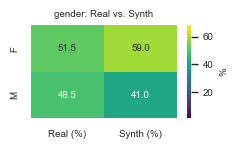

In [40]:

features = ["gender", "ethnicity", "age_group"]
global_min_diff, global_max_diff = get_global_range(distributions, features, mode="diff")
global_min_comp, global_max_comp = get_global_range(distributions, features, mode="comp")

fig = plot_heatmap_for_feature(
        distributions,
        feat="gender",
        vmin_vmax_diff=(global_min_diff, global_max_diff),
        vmin_vmax_comp=(global_min_comp, global_max_comp),
        fig_width=2.4, fig_height=1.5,
        show_diff_hm=False
    )
plt.show()
if SAVE_DATA:
    fig.savefig(OUTPUT_DIR_FIG / f"gender_heatmap_{timestamp}.tiff", dpi=300, format='tiff', bbox_inches='tight', pil_kwargs={'compression': 'tiff_lzw'})
plt.close(fig)
    

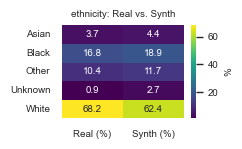

In [41]:
fig = plot_heatmap_for_feature(
        distributions,
        feat="ethnicity",
        vmin_vmax_diff=(global_min_diff, global_max_diff),
        vmin_vmax_comp=(global_min_comp, global_max_comp),
        fig_width=2.4, fig_height=1.5,
        show_diff_hm=False
    )
plt.show()
if SAVE_DATA:
    fig.savefig(OUTPUT_DIR_FIG / f"ethnicity_heatmap_{timestamp}.tiff", dpi=300, format='tiff', bbox_inches='tight', pil_kwargs={'compression': 'tiff_lzw'})
plt.close(fig)
    

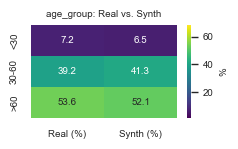

In [42]:
fig = plot_heatmap_for_feature(
        distributions,
        feat="age_group",
        vmin_vmax_diff=(global_min_diff, global_max_diff),
        vmin_vmax_comp=(global_min_comp, global_max_comp),
        fig_width=2.4, fig_height=1.5,
        show_diff_hm=False
    )
plt.show()
if SAVE_DATA:
    fig.savefig(OUTPUT_DIR_FIG / f"age_group_heatmap_{timestamp}.tiff", dpi=300, format='tiff', bbox_inches='tight', pil_kwargs={'compression': 'tiff_lzw'})
plt.close(fig)
    

In [44]:
display(cat_metrics)

KL_mean             Chi2_stat                   Chi2_p  \
               mean       std        mean        std          mean   
subgroup                                                             
age_group  0.001219  0.000622   12.124914   6.134523  3.679580e-02   
ethnicity  0.013302  0.002032  141.955409  21.328394  2.842746e-23   
gender     0.011638  0.002949  115.192605  29.056064  6.285951e-18   

                              MMD            
                    std      mean       std  
subgroup                                     
age_group  9.262931e-02  0.014072  0.006105  
ethnicity  8.987938e-23  0.037656  0.006233  
gender     3.347514e-17  0.066251  0.008242

wird als Tabelle präsentiert

In [ ]:
cat_metrics

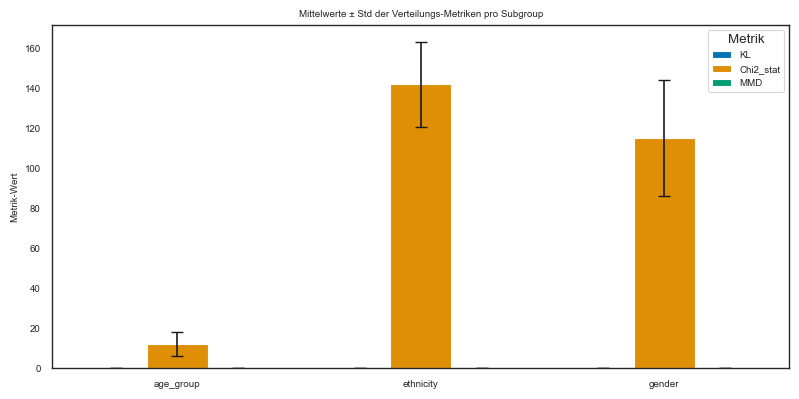

In [45]:
# 1. Flatten der MultiIndex-Spalten (falls nötig)
df = cat_metrics.copy()
df.columns = [
    "KL_mean", "KL_std",
    "Chi2_stat_mean", "Chi2_stat_std",
    "Chi2_p_mean", "Chi2_p_std",
    "MMD_mean", "MMD_std"
]

# 2. Auswahl der Metriken mit Mittelwert und Standardabweichung
metrics = ["KL", "Chi2_stat", "MMD"]
means = {m: df[f"{m}_mean"] for m in metrics}
stds  = {m: df[f"{m}_std"]  for m in metrics}

# 3. Plot-Einstellungen
x     = np.arange(len(df))      # Positionen für die Gruppen
width = 0.25                     # Breite der Balken
fig, ax = plt.subplots(figsize=(8, 4))

for i, m in enumerate(metrics):
    ax.bar(
        x + i*width,
        means[m],
        width,
        yerr=stds[m],
        capsize=4,
        label=m
    )

# 4. Achsen und Beschriftungen
ax.set_xticks(x + width*(len(metrics)-1)/2)
ax.set_xticklabels(df.index, rotation=0)
ax.set_ylabel("Metrik-Wert")
ax.set_title("Mittelwerte ± Std der Verteilungs-Metriken pro Subgroup")
ax.legend(title="Metrik")
fig.tight_layout()
plt.show()